In [3]:
import numpy as np
import pandas as pd
import os
from scipy import signal
from sklearn.datasets import load_boston
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.datasets import make_blobs

#DATA_PATH = os.path.join(os.path.dirname(__file__), "..", "data")
DATA_PATH = os.path.join("./")

def make_forge():
    # a carefully hand-designed dataset lol
    X, y = make_blobs(centers=2, random_state=4, n_samples=30)
    y[np.array([7, 27])] = 0
    mask = np.ones(len(X), dtype=np.bool)
    mask[np.array([0, 1, 5, 26])] = 0
    X, y = X[mask], y[mask]
    return X, y


def make_wave(n_samples=100):
    rnd = np.random.RandomState(42)
    x = rnd.uniform(-3, 3, size=n_samples)
    y_no_noise = (np.sin(4 * x) + x)
    y = (y_no_noise + rnd.normal(size=len(x))) / 2
    return x.reshape(-1, 1), y


def load_extended_boston():
    boston = load_boston()
    X = boston.data

    X = MinMaxScaler().fit_transform(boston.data)
    X = PolynomialFeatures(degree=2, include_bias=False).fit_transform(X)
    return X, boston.target


def load_citibike():
    data_mine = pd.read_csv(os.path.join(DATA_PATH, "citibike.csv"))
    data_mine['one'] = 1
    data_mine['starttime'] = pd.to_datetime(data_mine.starttime)
    data_starttime = data_mine.set_index("starttime")
    data_resampled = data_starttime.resample("3h").sum().fillna(0)
    return data_resampled.one


def make_signals():
    # fix a random state seed
    rng = np.random.RandomState(42)
    n_samples = 2000
    time = np.linspace(0, 8, n_samples)
    # create three signals
    s1 = np.sin(2 * time)  # Signal 1 : sinusoidal signal
    s2 = np.sign(np.sin(3 * time))  # Signal 2 : square signal
    s3 = signal.sawtooth(2 * np.pi * time)  # Signal 3: saw tooth signal

    # concatenate the signals, add noise
    S = np.c_[s1, s2, s3]
    S += 0.2 * rng.normal(size=S.shape)

    S /= S.std(axis=0)  # Standardize data
    S -= S.min()
    return S

In [6]:
citibike = load_citibike()

In [7]:
import numpy as np

P = citibike
Q = np.array(P).reshape(-1,1)

X1 = Q[0:-3, :]  # 予測対象日の3日前のデータ
X2 = Q[1:-2, :]  # 予測対象日の2日前のデータ
X3 = Q[2:-1, :]  # 予測対象日の前日データ
Y = Q[3:, :]  # 予測対象日のデータ
X = np.concatenate([X1, X2, X3], axis=1)  # numpy配列を結合する。

In [8]:
from sklearn.preprocessing import MinMaxScaler

In [9]:
scaler = MinMaxScaler()  # データを0～1の範囲にスケールするための関数。
scaler.fit(X)  # スケーリングに使用する最小／最大値を計算する。
X = scaler.transform(X)  # Xをを0～1の範囲にスケーリングする。
scaler1 = MinMaxScaler()  # データを0～1の範囲にスケールするための関数。
scaler1.fit(Y)  # スケーリングに使用する最小／最大値を計算する。
Y = scaler1.transform(Y)  # Yをを0～1の範囲にスケーリングする。

In [10]:
X = np.reshape(X, (X.shape[0], 1, X.shape[1]))  # 3次元配列に変換する。
# train, testデータを定義
X_train = X[:160, :, :]
X_test = X[160:, :, :]
Y_train = Y[:160, :]
Y_test = Y[160:, :]

In [11]:
from keras.models import Sequential
from keras.layers import Dense,  LSTM
from keras import metrics

model = Sequential()
model.add(LSTM(10, activation = 'tanh', input_shape = (1,3), recurrent_activation= 'hard_sigmoid'))
model.add(Dense(1))
model.compile(loss= 'mean_squared_error', optimizer = 'rmsprop', metrics=[metrics.mae])
model.fit(X_train, Y_train, epochs=100, verbose=2)

Epoch 1/100
5/5 - 2s - loss: 0.1481 - mean_absolute_error: 0.3070
Epoch 2/100
5/5 - 0s - loss: 0.1373 - mean_absolute_error: 0.2891
Epoch 3/100
5/5 - 0s - loss: 0.1298 - mean_absolute_error: 0.2760
Epoch 4/100
5/5 - 0s - loss: 0.1235 - mean_absolute_error: 0.2654
Epoch 5/100
5/5 - 0s - loss: 0.1178 - mean_absolute_error: 0.2560
Epoch 6/100
5/5 - 0s - loss: 0.1125 - mean_absolute_error: 0.2481
Epoch 7/100
5/5 - 0s - loss: 0.1075 - mean_absolute_error: 0.2415
Epoch 8/100
5/5 - 0s - loss: 0.1029 - mean_absolute_error: 0.2355
Epoch 9/100
5/5 - 0s - loss: 0.0984 - mean_absolute_error: 0.2305
Epoch 10/100
5/5 - 0s - loss: 0.0942 - mean_absolute_error: 0.2255
Epoch 11/100
5/5 - 0s - loss: 0.0903 - mean_absolute_error: 0.2209
Epoch 12/100
5/5 - 0s - loss: 0.0867 - mean_absolute_error: 0.2163
Epoch 13/100
5/5 - 0s - loss: 0.0832 - mean_absolute_error: 0.2120
Epoch 14/100
5/5 - 0s - loss: 0.0799 - mean_absolute_error: 0.2079
Epoch 15/100
5/5 - 0s - loss: 0.0768 - mean_absolute_error: 0.2053
Epoc

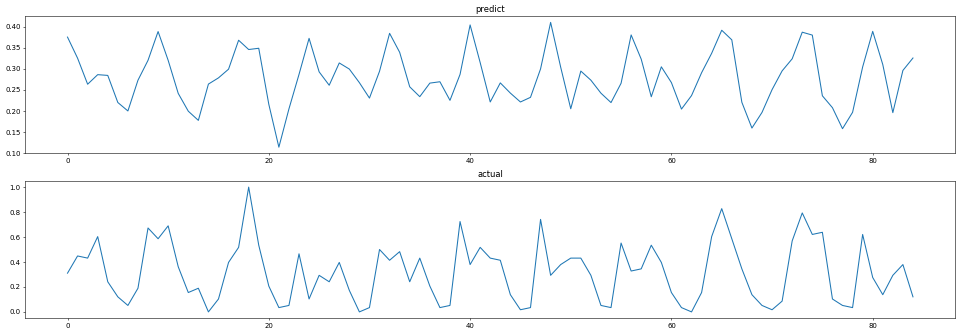

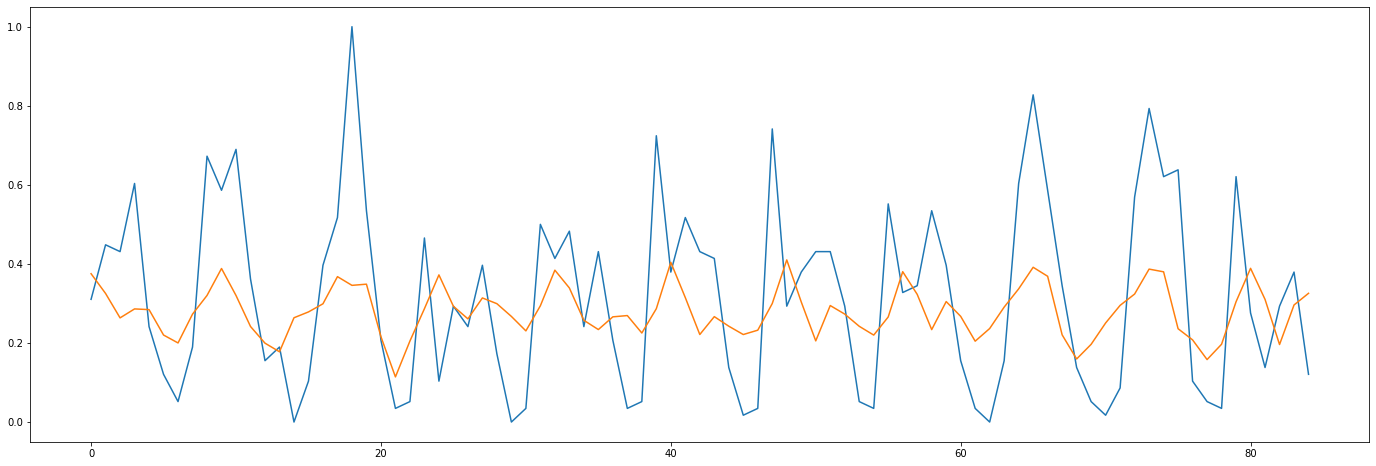

In [14]:
import matplotlib.pyplot as plt

Predict = model.predict(X_test)

#plt.figure(figsize=(24, 8), dpi=50)
#plt.plot(Predict)
#plt.plot(Y_test)

plt.figure(figsize=(24, 8), dpi=50)
plt.subplot(211)
plt.title("predict")
plt.plot(Predict)
plt.subplot(212)
plt.title("actual")
plt.plot(Y_test)


plt.figure(figsize=(24,8))
plt.plot(Y_test, label = 'Test')
plt.plot(Predict, label = 'Prediction')